# Tutorial: creating a Q2Q transform from zero

A Q2Q transform is a functional relationship between what you have and what you would like to have. It applies to random variables, because the relationship is between the quantiles of the input and the target random variables.

In this context, this tutorial shows how to generate Q2Q functions between modelled (input) and historical (target) renewable generation time series, for solar and wind power. Unless stated otherwise, hourly time series for one year will be considered.

This Q2Q encapsulate the modelling errors in a statistical sense, and can be used to improve the modelling of renewable generation in tasks related to energy system optimisation. Further details can be found at https://arxiv.org/abs/2412.06571.

## Gather your data

To implement a Q2Q transform, you basically need two time series:

- a time series with historical data, $g_{H,t}$, for a specific year of interest.

- a time series with modelled data, $g_{M,t}$, for the same time period.

$t$ refers to time index.

### Historical data

Obtaining historical data of renewable generation can be difficult, if not impossible.

Generation time series for Spain can be retrieved at https://api.esios.ree.es/.

> At the end of this section, the dataframe `df_target` with the input time series must be defined.

### Modelled data

Wind and solar time series at national level can be modelled with [PyPSA-Eur](https://github.com/PyPSA/pypsa-eur). Here we will use the Spanish extension of this model, [PyPSA-Spain](https://github.com/cristobal-GC/pypsa-spain).

For modelling accuracy, it is important to use an installed capacity layout for the considered technology that is as close as possible to the existing one in the specified year. In **PyPSA-Spain** you can use the functionality `update_elec_capacities` to impose the installed capacity for a specific technology at NUTS 2 level. The data of the installed capacity in Spain at NUTS 2 level can be retrieved at https://www.ree.es/es/apidatos.




It is also important to retain all relevant details and hypotheses of the implemented scenario, as different choices may lead to different generation time series. For example:

- Source of meteorological data

- Wind turbine model / PV panel configuration

- Correction factors

- ...





> At the end of this section, the dataframe `df_input` with the input time series must be defined.

In [6]:
########## Parameters

carrier = 'onwind'

In [16]:
import pypsa

n_file = '../examples/base_s_15___2013.nc'

n = pypsa.Network(n_file)

INFO:pypsa.io:Imported network base_s_15___2013.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [17]:
df_input = n.generators_t['p'].filter(like=carrier).sum(axis=1).to_frame(name=carrier)

<Axes: xlabel='snapshot'>

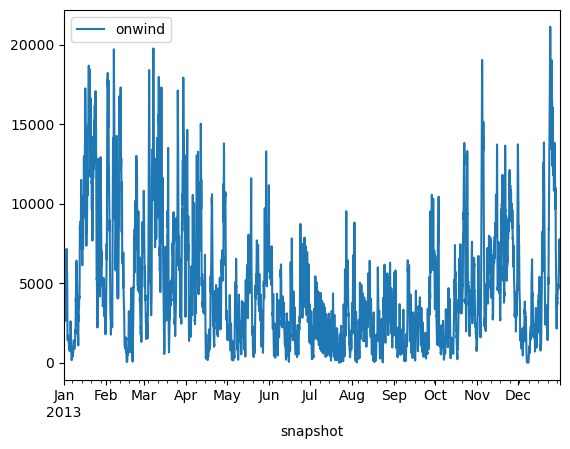

In [18]:
df_input.plot()

In [19]:
import pypsa

n_file = '../examples/base_s_15___2023.nc'

n = pypsa.Network(n_file)

INFO:pypsa.io:Imported network base_s_15___2023.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [20]:
df_input = n.generators_t['p'].filter(like=carrier).sum(axis=1).to_frame(name=carrier)

<Axes: xlabel='snapshot'>

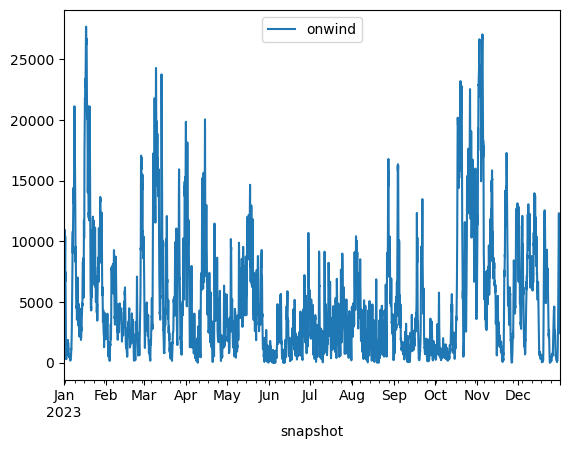

In [21]:
df_input.plot()